In [113]:
!pip install ortools
!pip install torch torch-geometric numpy matplotlib

## **FIRST ITERATION**

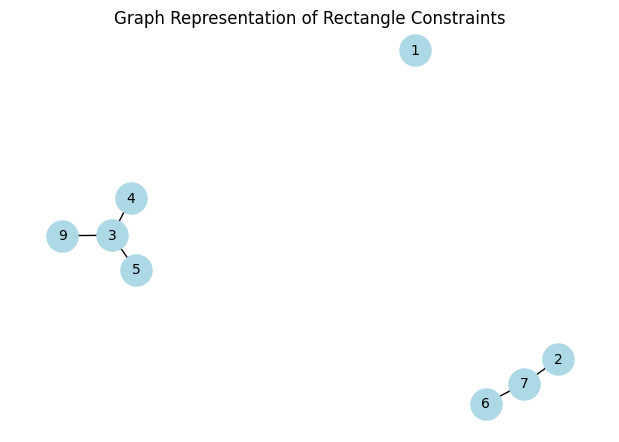

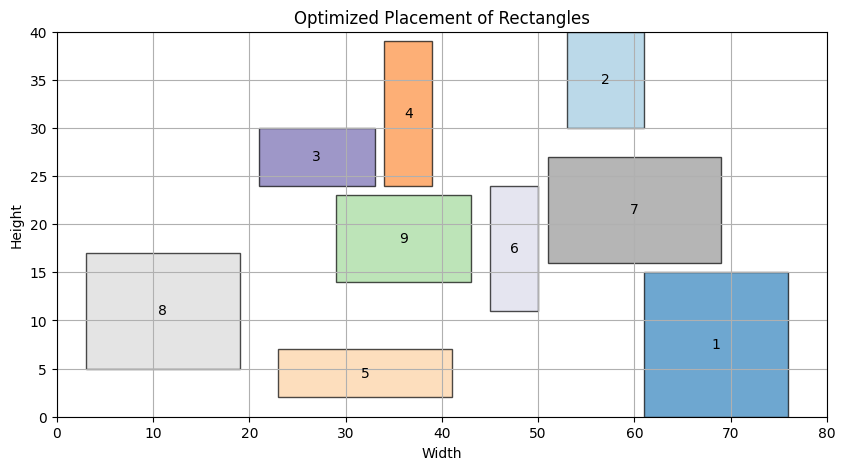

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

BIN_WIDTH = 80
BIN_HEIGHT = 40

np.random.seed(42)

def generate_rectangle_sizes(num_rectangles, max_width, max_height):
    return [(random.randint(5, max_width), random.randint(5, max_height)) for _ in range(num_rectangles)]

rectangles = generate_rectangle_sizes(9, 20, 15)

constraints = {
    1: {"position": "top"},
    2: {"position": "bottom"},
    3: {"close_to": [4, 5, 9]},
    7: {"close_to": [6, 2]},
}

G = nx.Graph()
for rect, props in constraints.items():
    G.add_node(rect)
    if "close_to" in props:
        for neighbor in props["close_to"]:
            G.add_edge(rect, neighbor)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Graph Representation of Rectangle Constraints")
plt.show()

bin_layout = np.zeros((BIN_HEIGHT, BIN_WIDTH), dtype=int)
placements = {}

def is_overlap(bin_layout, x, y, width, height):
    if x + width + 1 > BIN_WIDTH or y + height + 1 > BIN_HEIGHT or x < 0 or y < 0:
        return True
    return np.any(bin_layout[max(0, y - 1):min(BIN_HEIGHT, y + height + 1), max(0, x - 1):min(BIN_WIDTH, x + width + 1)] > 0)

def place_rectangle(rect_id, width, height, x=None, y=None):
    if x is None or y is None:
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        while is_overlap(bin_layout, x, y, width, height):
            x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
    bin_layout[y:y + height, x:x + width] = rect_id
    placements[rect_id] = (x, y, width, height)

place_rectangle(1, rectangles[0][0], rectangles[0][1], x=random.randint(0, BIN_WIDTH - rectangles[0][0]), y=0)
place_rectangle(2, rectangles[1][0], rectangles[1][1], x=random.randint(0, BIN_WIDTH - rectangles[1][0]), y=BIN_HEIGHT - rectangles[1][1])

def place_close_to(rect_id, width, height, close_to_ids):
    placed_coords = [placements[close_id] for close_id in close_to_ids if close_id in placements]
    if placed_coords:
        for px, py, pwidth, pheight in placed_coords:
            for dx in range(-width - 1, width + 2):
                for dy in range(-height - 1, height + 2):
                    x = max(0, min(BIN_WIDTH - width, px + dx))
                    y = max(0, min(BIN_HEIGHT - height, py + dy))
                    if not is_overlap(bin_layout, x, y, width, height):
                        place_rectangle(rect_id, width, height, x, y)
                        return True
    return False

place_rectangle(4, rectangles[3][0], rectangles[3][1])
place_rectangle(5, rectangles[4][0], rectangles[4][1])
place_rectangle(9, rectangles[8][0], rectangles[8][1])
place_close_to(3, rectangles[2][0], rectangles[2][1], constraints[3]["close_to"])
place_rectangle(6, rectangles[5][0], rectangles[5][1])
place_close_to(7, rectangles[6][0], rectangles[6][1], constraints[7]["close_to"])

def place_remaining():
    for rect_id, (width, height) in enumerate(rectangles, start=1):
        if rect_id not in placements:
            while True:
                x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
                if not is_overlap(bin_layout, x, y, width, height):
                    place_rectangle(rect_id, width, height, x, y)
                    break

place_remaining()

colors = plt.cm.tab20c(np.linspace(0, 1, len(placements)))

plt.figure(figsize=(10, 5))
for idx, (rect_id, (x, y, width, height)) in enumerate(placements.items()):
    color = colors[idx]
    plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='black', facecolor=color, alpha=0.7))
    plt.text(x + width / 2, y + height / 2, f"{rect_id}", ha='center', va='center', color='black')

plt.xlim(0, BIN_WIDTH)
plt.ylim(0, BIN_HEIGHT)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Optimized Placement of Rectangles")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid(True)
plt.show()


## **SECOND ITERATION**

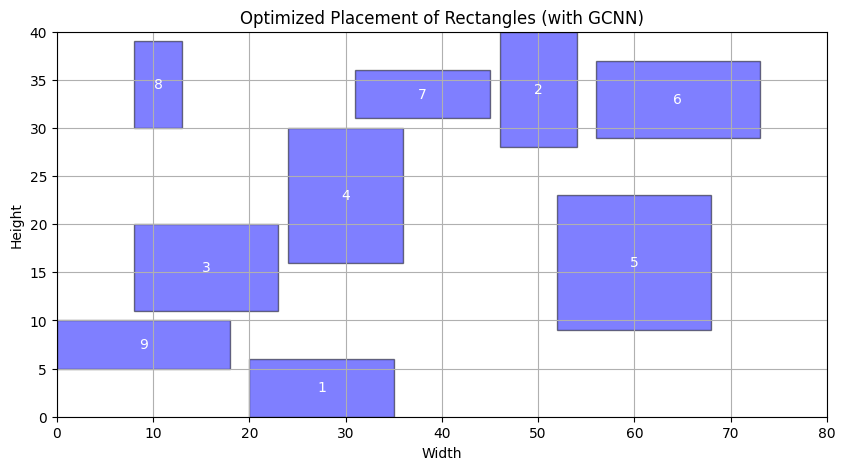

In [136]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

BIN_WIDTH = 80
BIN_HEIGHT = 40

np.random.seed(42)

def generate_rectangle_sizes(num_rectangles, max_width, max_height):
    return [(random.randint(5, max_width), random.randint(5, max_height)) for _ in range(num_rectangles)]

rectangles = generate_rectangle_sizes(9, 20, 15)

constraints = {
    1: {"position": "top"},
    2: {"position": "bottom"},
    3: {"close_to": [4, 5, 9]},
    7: {"close_to": [6, 2]},
}

bin_layout = np.zeros((BIN_HEIGHT, BIN_WIDTH), dtype=int)
placements = {}

def is_overlap(bin_layout, x, y, width, height):
    if x + width + 1 > BIN_WIDTH or y + height + 1 > BIN_HEIGHT or x < 0 or y < 0:
        return True
    return np.any(bin_layout[max(0, y - 1):min(BIN_HEIGHT, y + height + 1), max(0, x - 1):min(BIN_WIDTH, x + width + 1)] > 0)

def place_rectangle(rect_id, width, height, x=None, y=None):
    if x is None or y is None:
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        while is_overlap(bin_layout, x, y, width, height):
            x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
    bin_layout[y:y + height, x:x + width] = rect_id
    placements[rect_id] = (x, y, width, height)

def place_close_to(rect_id, width, height, close_to_ids):
    placed_coords = [placements[close_id] for close_id in close_to_ids if close_id in placements]
    if placed_coords:
        for px, py, pwidth, pheight in placed_coords:
            for dx in range(-width - 1, width + 2):
                for dy in range(-height - 1, height + 2):
                    x = max(0, min(BIN_WIDTH - width, px + dx))
                    y = max(0, min(BIN_HEIGHT - height, py + dy))
                    if not is_overlap(bin_layout, x, y, width, height):
                        place_rectangle(rect_id, width, height, x, y)
                        return True
    return False

place_rectangle(1, rectangles[0][0], rectangles[0][1], x=random.randint(0, BIN_WIDTH - rectangles[0][0]), y=0)
place_rectangle(2, rectangles[1][0], rectangles[1][1], x=random.randint(0, BIN_WIDTH - rectangles[1][0]), y=BIN_HEIGHT - rectangles[1][1])
place_rectangle(4, rectangles[3][0], rectangles[3][1])
place_rectangle(5, rectangles[4][0], rectangles[4][1])
place_rectangle(9, rectangles[8][0], rectangles[8][1])
place_close_to(3, rectangles[2][0], rectangles[2][1], constraints[3]["close_to"])
place_rectangle(6, rectangles[5][0], rectangles[5][1])
place_close_to(7, rectangles[6][0], rectangles[6][1], constraints[7]["close_to"])

def place_remaining():
    for rect_id, (width, height) in enumerate(rectangles, start=1):
        if rect_id not in placements:
            while True:
                x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
                if not is_overlap(bin_layout, x, y, width, height):
                    place_rectangle(rect_id, width, height, x, y)
                    break

place_remaining()

class GCNN(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

G = nx.Graph()
for rect, props in constraints.items():
    G.add_node(rect)
    if "close_to" in props:
        for neighbor in props["close_to"]:
            G.add_edge(rect, neighbor)

edges = [(edge[0] - 1, edge[1] - 1) for edge in list(G.edges())]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

node_features = torch.tensor([list(rect) for rect in rectangles], dtype=torch.float)

data = Data(x=node_features, edge_index=edge_index)

gcnn = GCNN(num_features=2, hidden_dim=16, output_dim=2)
optimizer = optim.Adam(gcnn.parameters(), lr=0.01)

def reward_function(placements, bin_layout, constraints):
    reward = 0
    area_used = np.sum(bin_layout > 0)
    reward += area_used

    for rect_id, props in constraints.items():
        if "close_to" in props:
            for neighbor_id in props["close_to"]:
                if neighbor_id in placements:
                    x1, y1, w1, h1 = placements[rect_id]
                    x2, y2, w2, h2 = placements[neighbor_id]
                    distance = np.linalg.norm(np.array([x1 + w1 / 2, y1 + h1 / 2]) - np.array([x2 + w2 / 2, y2 + h2 / 2]))
                    if distance < 5:
                        reward += 10

    for rect_id, (x, y, w, h) in placements.items():
        if np.any(bin_layout[y:y + h, x:x + w] > 1):
            reward -= 50

    return torch.tensor(reward, dtype=torch.float, requires_grad=True)

def map_gcnn_to_placements(output):
    placements = {}
    for i, out in enumerate(output):
        rect_id = i + 1
        width, height = rectangles[i]
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        placements[rect_id] = (x, y, width, height)
    return placements

def train_rl(agent, optimizer, epochs=100):
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = agent(data)
        placements = map_gcnn_to_placements(out)
        reward = reward_function(placements, bin_layout, constraints)

        reward.backward()
        optimizer.step()

def visualize_placements():
    plt.figure(figsize=(10, 5))
    for rect_id, (x, y, width, height) in placements.items():
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='black', facecolor='blue', alpha=0.5))
        plt.text(x + width / 2, y + height / 2, f"{rect_id}", ha='center', va='center', color='white')

    plt.xlim(0, BIN_WIDTH)
    plt.ylim(0, BIN_HEIGHT)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Optimized Placement of Rectangles (with GCNN)")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

train_rl(gcnn, optimizer, epochs=100)

visualize_placements()


## **THIRD ITERATION**

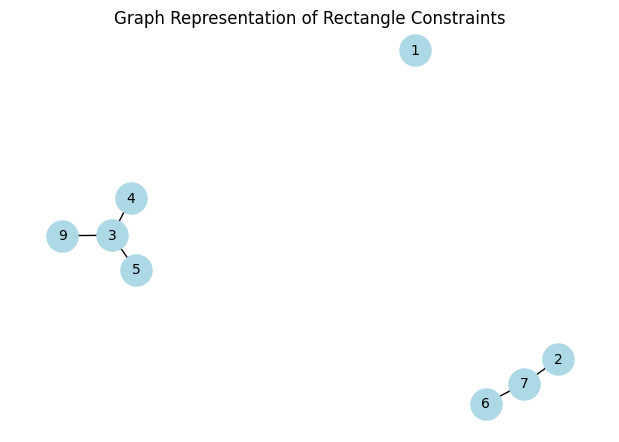

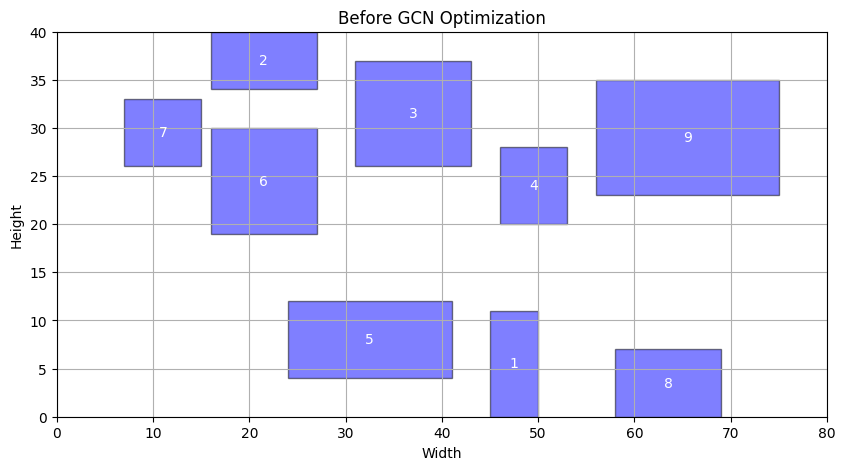

Epoch [0/5000], Loss: 904.3318
Epoch [50/5000], Loss: 115.5095
Epoch [100/5000], Loss: 10.6306
Epoch [150/5000], Loss: 1.9557
Epoch [200/5000], Loss: 0.6713
Epoch [250/5000], Loss: 0.2707
Epoch [300/5000], Loss: 0.1227
Epoch [350/5000], Loss: 0.0686
Epoch [400/5000], Loss: 0.0436
Epoch [450/5000], Loss: 0.0274
Epoch [500/5000], Loss: 0.0169
Epoch [550/5000], Loss: 0.0101
Epoch [600/5000], Loss: 0.0059
Epoch [650/5000], Loss: 0.0035
Epoch [700/5000], Loss: 0.0022
Epoch [750/5000], Loss: 0.0013
Epoch [800/5000], Loss: 0.0008
Epoch [850/5000], Loss: 0.0005
Epoch [900/5000], Loss: 0.0003
Epoch [950/5000], Loss: 0.0002
Epoch [1000/5000], Loss: 0.0001
Epoch [1050/5000], Loss: 0.0001
Epoch [1100/5000], Loss: 0.0001
Epoch [1150/5000], Loss: 0.0000
Epoch [1200/5000], Loss: 0.0000
Epoch [1250/5000], Loss: 0.0000
Epoch [1300/5000], Loss: 0.0000
Epoch [1350/5000], Loss: 0.0000
Epoch [1400/5000], Loss: 0.0000
Epoch [1450/5000], Loss: 0.0000
Epoch [1500/5000], Loss: 0.0000
Epoch [1550/5000], Loss: 0

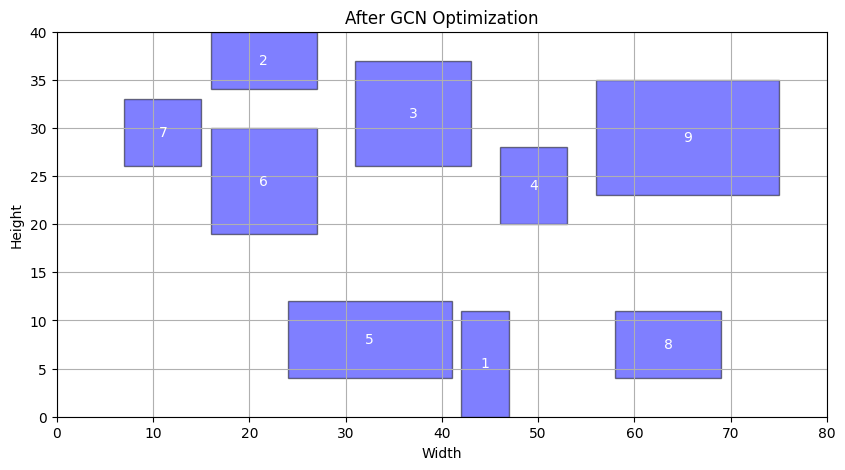

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim

BIN_WIDTH = 80
BIN_HEIGHT = 40

np.random.seed(42)

def generate_rectangle_sizes(num_rectangles, max_width, max_height):
    return [
        (random.randint(5, max_width), random.randint(5, max_height))
        for _ in range(num_rectangles)
    ]

rectangles = generate_rectangle_sizes(9, 20, 15)

constraints = {
    1: {"position": "top"},
    2: {"position": "bottom"},
    3: {"close_to": [4, 5, 9]},
    7: {"close_to": [6, 2]},
}

G = nx.Graph()
for rect, props in constraints.items():
    G.add_node(rect)
    if "close_to" in props:
        for neighbor in props["close_to"]:
            G.add_edge(rect, neighbor)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Graph Representation of Rectangle Constraints")
plt.show()

bin_layout = np.zeros((BIN_HEIGHT, BIN_WIDTH), dtype=int)
placements = {}

def is_overlap(bin_layout, x, y, width, height):
    if x + width + 1 > BIN_WIDTH or y + height + 1 > BIN_HEIGHT or x < 0 or y < 0:
        return True
    return np.any(bin_layout[max(0, y - 1):min(BIN_HEIGHT, y + height + 1), max(0, x - 1):min(BIN_WIDTH, x + width + 1)] > 0)

def place_rectangle(rect_id, width, height, x=None, y=None):
    if x is None or y is None:
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        while is_overlap(bin_layout, x, y, width, height):
            x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
    bin_layout[y:y + height, x:x + width] = rect_id
    placements[rect_id] = (x, y, width, height)

place_rectangle(1, rectangles[0][0], rectangles[0][1], x=random.randint(0, BIN_WIDTH - rectangles[0][0]), y=0)
place_rectangle(2, rectangles[1][0], rectangles[1][1], x=random.randint(0, BIN_WIDTH - rectangles[1][0]), y=BIN_HEIGHT - rectangles[1][1])

def place_close_to(rect_id, width, height, close_to_ids):
    placed_coords = [placements[close_id] for close_id in close_to_ids if close_id in placements]
    if placed_coords:
        for px, py, pwidth, pheight in placed_coords:
            for dx in range(-width - 1, width + 2):
                for dy in range(-height - 1, height + 2):
                    x = max(0, min(BIN_WIDTH - width, px + dx))
                    y = max(0, min(BIN_HEIGHT - height, py + dy))
                    if not is_overlap(bin_layout, x, y, width, height):
                        place_rectangle(rect_id, width, height, x, y)
                        return True
    return False

place_close_to(3, rectangles[2][0], rectangles[2][1], constraints[3]["close_to"])
place_close_to(7, rectangles[6][0], rectangles[6][1], constraints[7]["close_to"])

def place_remaining():
    for rect_id, (width, height) in enumerate(rectangles, start=1):
        if rect_id not in placements:
            while True:
                x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
                if not is_overlap(bin_layout, x, y, width, height):
                    place_rectangle(rect_id, width, height, x, y)
                    break

place_remaining()

class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=1)
        self.fc1 = nn.Linear(out_features, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(0)

def prepare_graph_data(constraints, rectangles):
    num_rectangles = len(rectangles)
    adjacency_matrix = np.zeros((num_rectangles, num_rectangles))
    feature_matrix = np.zeros((num_rectangles, 4))

    for rect_id, props in constraints.items():
        if "close_to" in props:
            for neighbor in props["close_to"]:
                adjacency_matrix[rect_id - 1, neighbor - 1] = 1
                adjacency_matrix[neighbor - 1, rect_id - 1] = 1

    for rect_id, (width, height) in enumerate(rectangles, start=1):
        x, y, _, _ = placements.get(rect_id, (random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height), width, height))
        feature_matrix[rect_id - 1] = [x, y, width, height]

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32, requires_grad=True)

    return adjacency_matrix, feature_matrix

def optimize_with_gcn():
    adjacency_matrix, feature_matrix = prepare_graph_data(constraints, rectangles)
    model = GCN(in_features=4, out_features=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    feature_matrix = feature_matrix.unsqueeze(0).transpose(1, 2)

    for epoch in range(5000):
        model.train()
        output = model(feature_matrix)

        if output.size(0) != len(rectangles) or output.size(1) != 2:
            raise ValueError("GCN output must have shape [num_rectangles, 2]. Got: {}".format(output.shape))

        for i in range(output.size(0)):
            rect_id = i + 1
            if rect_id in [1, 2]:
                new_x = output[i][0].detach().numpy()
                _, y, width, height = placements[rect_id]

                new_x = max(0, min(BIN_WIDTH - width, int(new_x)))

                if not is_overlap(bin_layout, new_x, y, width, height):
                    x, y, w, h = placements[rect_id]
                    bin_layout[y:y + h, x:x + w] = 0

                    placements[rect_id] = (new_x, y, width, height)
                    bin_layout[y:y + height, new_x:new_x + width] = rect_id
                continue

            new_x, new_y = output[i].detach().numpy()
            _, _, width, height = placements[rect_id]

            new_x = max(0, min(BIN_WIDTH - width, int(new_x)))
            new_y = max(0, min(BIN_HEIGHT - height, int(new_y)))

            if not is_overlap(bin_layout, new_x, new_y, width, height):
                x, y, w, h = placements[rect_id]
                bin_layout[y:y + h, x:x + w] = 0

                placements[rect_id] = (new_x, new_y, width, height)
                bin_layout[new_y:new_y + height, new_x:new_x + width] = rect_id

        loss = torch.mean((output - feature_matrix[0, :2].transpose(0, 1)) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/5000], Loss: {loss.item():.4f}")

def plot_placement(placements, width, height, title=""):
    plt.figure(figsize=(10, 5))
    for rect_id, (x, y, w, h) in placements.items():
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='black', facecolor='blue', alpha=0.5))
        plt.text(x + w / 2, y + h / 2, f"{rect_id}", ha='center', va='center', color='white')

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "Before GCN Optimization")
optimize_with_gcn()
plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "After GCN Optimization")


## **FOURTH ITERATION**

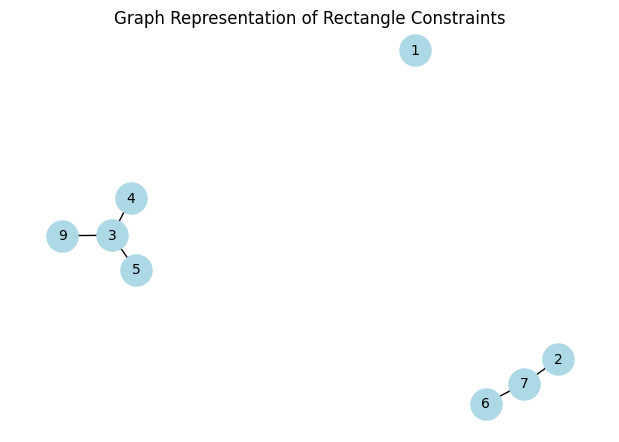

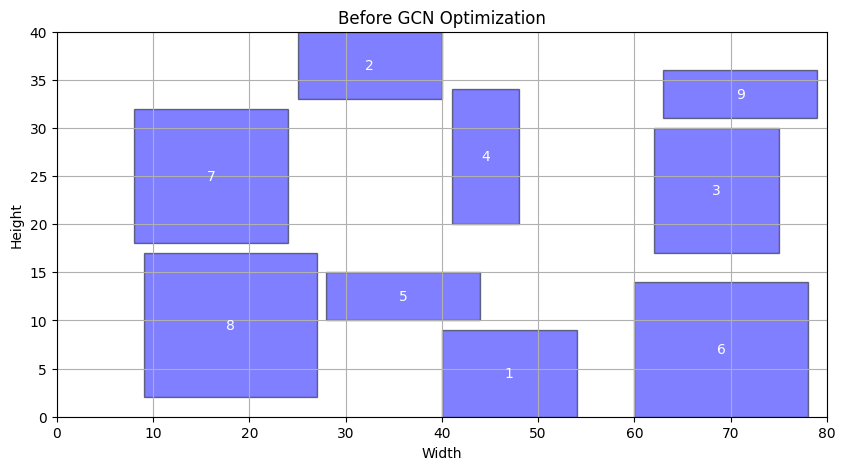

Epoch [0/5000], Loss: 1087.2544
Epoch [50/5000], Loss: 169.5217
Epoch [100/5000], Loss: 83.4068
Epoch [150/5000], Loss: 80.3617
Epoch [200/5000], Loss: 79.4989
Epoch [250/5000], Loss: 78.8301
Epoch [300/5000], Loss: 78.2761
Epoch [350/5000], Loss: 77.8084
Epoch [400/5000], Loss: 77.4010
Epoch [450/5000], Loss: 77.0308
Epoch [500/5000], Loss: 76.6753
Epoch [550/5000], Loss: 76.3186
Epoch [600/5000], Loss: 75.9474
Epoch [650/5000], Loss: 75.5524
Epoch [700/5000], Loss: 75.1295
Epoch [750/5000], Loss: 74.6745
Epoch [800/5000], Loss: 74.1876
Epoch [850/5000], Loss: 73.6724
Epoch [900/5000], Loss: 73.1358
Epoch [950/5000], Loss: 72.5877
Epoch [1000/5000], Loss: 72.0401
Epoch [1050/5000], Loss: 71.5055
Epoch [1100/5000], Loss: 70.9975
Epoch [1150/5000], Loss: 70.5289
Epoch [1200/5000], Loss: 70.1072
Epoch [1250/5000], Loss: 69.7410
Epoch [1300/5000], Loss: 69.4324
Epoch [1350/5000], Loss: 69.0799
Epoch [1400/5000], Loss: 68.7320
Epoch [1450/5000], Loss: 68.4992
Epoch [1500/5000], Loss: 68.30

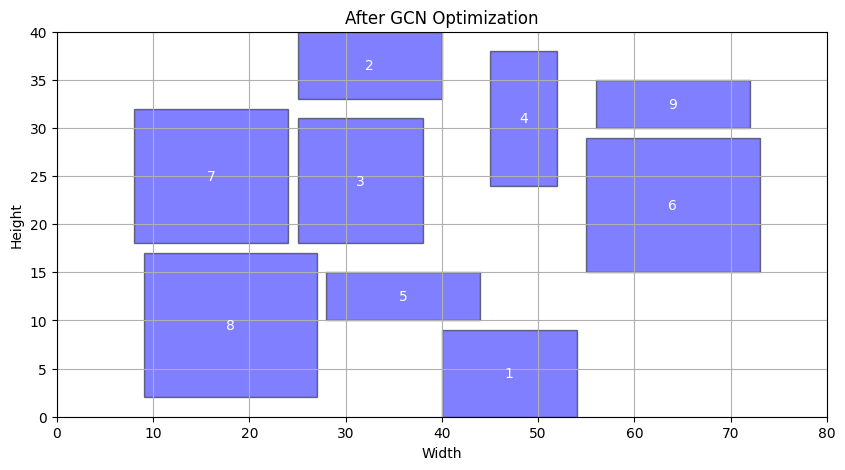

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim

BIN_WIDTH = 80
BIN_HEIGHT = 40

np.random.seed(42)

def generate_rectangle_sizes(num_rectangles, max_width, max_height):
    return [
        (random.randint(5, max_width), random.randint(5, max_height))
        for _ in range(num_rectangles)
    ]

rectangles = generate_rectangle_sizes(9, 20, 15)

constraints = {
    1: {"position": "top"},
    2: {"position": "bottom"},
    3: {"close_to": [4, 5, 9]},
    7: {"close_to": [6, 2]},
}

G = nx.Graph()
for rect, props in constraints.items():
    G.add_node(rect)
    if "close_to" in props:
        for neighbor in props["close_to"]:
            G.add_edge(rect, neighbor)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Graph Representation of Rectangle Constraints")
plt.show()

bin_layout = np.zeros((BIN_HEIGHT, BIN_WIDTH), dtype=int)
placements = {}

def is_overlap(bin_layout, x, y, width, height):
    if x + width + 1 > BIN_WIDTH or y + height + 1 > BIN_HEIGHT or x < 0 or y < 0:
        return True
    return np.any(bin_layout[max(0, y - 1):min(BIN_HEIGHT, y + height + 1), max(0, x - 1):min(BIN_WIDTH, x + width + 1)] > 0)

def place_rectangle(rect_id, width, height, x=None, y=None):
    if x is None or y is None:
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        while is_overlap(bin_layout, x, y, width, height):
            x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
    bin_layout[y:y + height, x:x + width] = rect_id
    placements[rect_id] = (x, y, width, height)

place_rectangle(1, rectangles[0][0], rectangles[0][1], x=random.randint(0, BIN_WIDTH - rectangles[0][0]), y=0)
place_rectangle(2, rectangles[1][0], rectangles[1][1], x=random.randint(0, BIN_WIDTH - rectangles[1][0]), y=BIN_HEIGHT - rectangles[1][1])

def place_close_to(rect_id, width, height, close_to_ids):
    placed_coords = [placements[close_id] for close_id in close_to_ids if close_id in placements]
    if placed_coords:
        for px, py, pwidth, pheight in placed_coords:
            for dx in range(-width - 1, width + 2):
                for dy in range(-height - 1, height + 2):
                    x = max(0, min(BIN_WIDTH - width, px + dx))
                    y = max(0, min(BIN_HEIGHT - height, py + dy))
                    if not is_overlap(bin_layout, x, y, width, height):
                        place_rectangle(rect_id, width, height, x, y)
                        return True
    return False

place_close_to(3, rectangles[2][0], rectangles[2][1], constraints[3]["close_to"])
place_close_to(7, rectangles[6][0], rectangles[6][1], constraints[7]["close_to"])

def place_remaining():
    for rect_id, (width, height) in enumerate(rectangles, start=1):
        if rect_id not in placements:
            while True:
                x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
                if not is_overlap(bin_layout, x, y, width, height):
                    place_rectangle(rect_id, width, height, x, y)
                    break

place_remaining()

class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=1)
        self.fc1 = nn.Linear(out_features, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(0)

def prepare_graph_data(constraints, rectangles):
    num_rectangles = len(rectangles)
    adjacency_matrix = np.zeros((num_rectangles, num_rectangles))
    feature_matrix = np.zeros((num_rectangles, 4))

    for rect_id, props in constraints.items():
        if "close_to" in props:
            for neighbor in props["close_to"]:
                adjacency_matrix[rect_id - 1, neighbor - 1] = 1
                adjacency_matrix[neighbor - 1, rect_id - 1] = 1

    for rect_id, (width, height) in enumerate(rectangles, start=1):
        x, y, _, _ = placements.get(rect_id, (random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height), width, height))
        feature_matrix[rect_id - 1] = [x, y, width, height]

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32, requires_grad=True)

    return adjacency_matrix, feature_matrix

def optimize_with_gcn():
    adjacency_matrix, feature_matrix = prepare_graph_data(constraints, rectangles)
    model = GCN(in_features=4, out_features=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    feature_matrix = feature_matrix.unsqueeze(0).transpose(1, 2)

    for epoch in range(5000):
        model.train()
        output = model(feature_matrix)

        if output.size(0) != len(rectangles) or output.size(1) != 2:
            raise ValueError("GCN output must have shape [num_rectangles, 2]. Got: {}".format(output.shape))

        for i in range(output.size(0)):
            rect_id = i + 1
            if rect_id in [1, 2]:
                continue

            new_x, new_y = output[i].detach().numpy()
            _, _, width, height = placements[rect_id]

            new_x = max(0, min(BIN_WIDTH - width, int(new_x)))
            new_y = max(0, min(BIN_HEIGHT - height, int(new_y)))

            if not is_overlap(bin_layout, new_x, new_y, width, height):
                x, y, w, h = placements[rect_id]
                bin_layout[y:y + h, x:x + w] = 0

                placements[rect_id] = (new_x, new_y, width, height)
                bin_layout[new_y:new_y + height, new_x:new_x + width] = rect_id

        loss = torch.mean((output - feature_matrix[0, :2].transpose(0, 1)) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/5000], Loss: {loss.item():.4f}")

def plot_placement(placements, width, height, title=""):
    plt.figure(figsize=(10, 5))
    for rect_id, (x, y, w, h) in placements.items():
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='black', facecolor='blue', alpha=0.5))
        plt.text(x + w / 2, y + h / 2, f"{rect_id}", ha='center', va='center', color='white')

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "Before GCN Optimization")
optimize_with_gcn()
plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "After GCN Optimization")


## **FIFTH ITERATION**

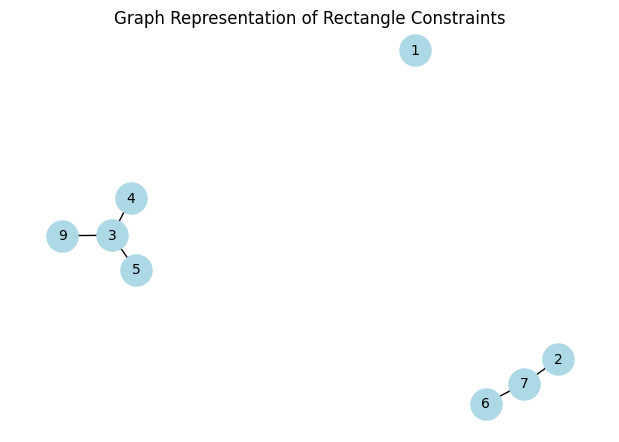

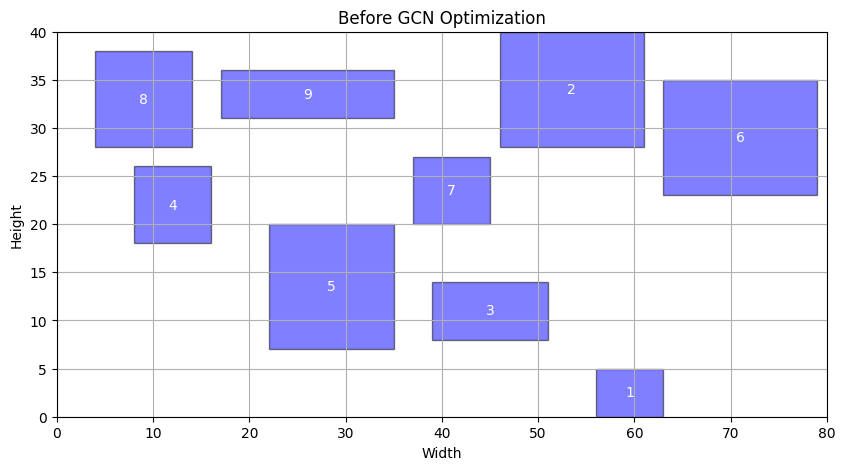

Epoch [0/5000], Loss: 925.4675
Epoch [50/5000], Loss: 124.3803
Epoch [100/5000], Loss: 106.1619
Epoch [150/5000], Loss: 102.3072
Epoch [200/5000], Loss: 99.2896
Epoch [250/5000], Loss: 96.2614
Epoch [300/5000], Loss: 92.7668
Epoch [350/5000], Loss: 88.7624
Epoch [400/5000], Loss: 84.3428
Epoch [450/5000], Loss: 79.6214
Epoch [500/5000], Loss: 74.7360
Epoch [550/5000], Loss: 69.8698
Epoch [600/5000], Loss: 65.2318
Epoch [650/5000], Loss: 61.0037
Epoch [700/5000], Loss: 57.3265
Epoch [750/5000], Loss: 54.2747
Epoch [800/5000], Loss: 51.8789
Epoch [850/5000], Loss: 50.0851
Epoch [900/5000], Loss: 48.7997
Epoch [950/5000], Loss: 47.9139
Epoch [1000/5000], Loss: 47.3253
Epoch [1050/5000], Loss: 46.9278
Epoch [1100/5000], Loss: 46.6578
Epoch [1150/5000], Loss: 46.4848
Epoch [1200/5000], Loss: 46.3771
Epoch [1250/5000], Loss: 46.2870
Epoch [1300/5000], Loss: 46.2250
Epoch [1350/5000], Loss: 46.1733
Epoch [1400/5000], Loss: 46.1347
Epoch [1450/5000], Loss: 46.0952
Epoch [1500/5000], Loss: 46.0

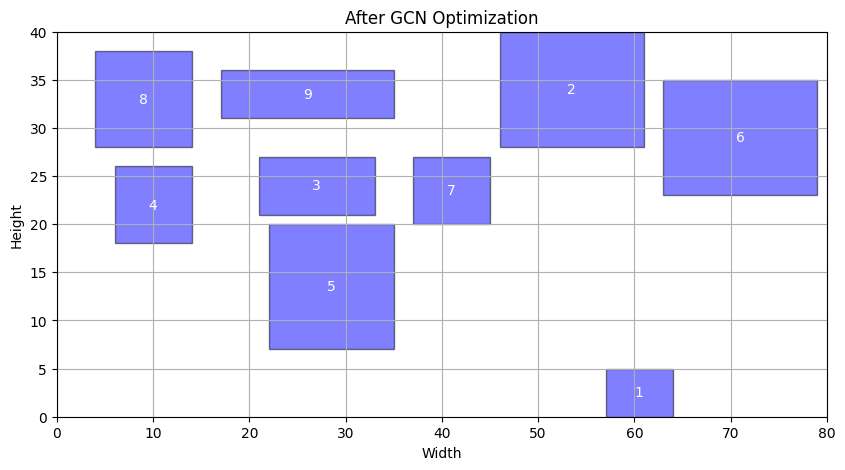

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.optim as optim

BIN_WIDTH = 80
BIN_HEIGHT = 40

np.random.seed(42)

def generate_rectangle_sizes(num_rectangles, max_width, max_height):
    return [
        (random.randint(5, max_width), random.randint(5, max_height))
        for _ in range(num_rectangles)
    ]

rectangles = generate_rectangle_sizes(9, 20, 15)

constraints = {
    1: {"position": "top"},
    2: {"position": "bottom"},
    3: {"close_to": [4, 5, 9]},
    7: {"close_to": [6, 2]},
}

G = nx.Graph()
for rect, props in constraints.items():
    G.add_node(rect)
    if "close_to" in props:
        for neighbor in props["close_to"]:
            G.add_edge(rect, neighbor)

plt.figure(figsize=(6, 4))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("Graph Representation of Rectangle Constraints")
plt.show()

bin_layout = np.zeros((BIN_HEIGHT, BIN_WIDTH), dtype=int)
placements = {}

def is_overlap(bin_layout, x, y, width, height):
    if x + width + 1 > BIN_WIDTH or y + height + 1 > BIN_HEIGHT or x < 0 or y < 0:
        return True
    return np.any(bin_layout[max(0, y - 1):min(BIN_HEIGHT, y + height + 1), max(0, x - 1):min(BIN_WIDTH, x + width + 1)] > 0)

def place_rectangle(rect_id, width, height, x=None, y=None):
    if x is None or y is None:
        x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
        while is_overlap(bin_layout, x, y, width, height):
            x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
    bin_layout[y:y + height, x:x + width] = rect_id
    placements[rect_id] = (x, y, width, height)

place_rectangle(1, rectangles[0][0], rectangles[0][1], x=random.randint(0, BIN_WIDTH - rectangles[0][0]), y=0)
place_rectangle(2, rectangles[1][0], rectangles[1][1], x=random.randint(0, BIN_WIDTH - rectangles[1][0]), y=BIN_HEIGHT - rectangles[1][1])

def place_close_to(rect_id, width, height, close_to_ids):
    placed_coords = [placements[close_id] for close_id in close_to_ids if close_id in placements]
    if placed_coords:
        for px, py, pwidth, pheight in placed_coords:
            for dx in range(-width - 1, width + 2):
                for dy in range(-height - 1, height + 2):
                    x = max(0, min(BIN_WIDTH - width, px + dx))
                    y = max(0, min(BIN_HEIGHT - height, py + dy))
                    if not is_overlap(bin_layout, x, y, width, height):
                        place_rectangle(rect_id, width, height, x, y)
                        return True
    return False

place_close_to(3, rectangles[2][0], rectangles[2][1], constraints[3]["close_to"])
place_close_to(7, rectangles[6][0], rectangles[6][1], constraints[7]["close_to"])

def place_remaining():
    for rect_id, (width, height) in enumerate(rectangles, start=1):
        if rect_id not in placements:
            while True:
                x, y = random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height)
                if not is_overlap(bin_layout, x, y, width, height):
                    place_rectangle(rect_id, width, height, x, y)
                    break

place_remaining()

class GCN(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_features, out_channels=64, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=1)
        self.fc1 = nn.Linear(out_features, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(0)

def prepare_graph_data(constraints, rectangles):
    num_rectangles = len(rectangles)
    adjacency_matrix = np.zeros((num_rectangles, num_rectangles))
    feature_matrix = np.zeros((num_rectangles, 4))

    for rect_id, props in constraints.items():
        if "close_to" in props:
            for neighbor in props["close_to"]:
                adjacency_matrix[rect_id - 1, neighbor - 1] = 1
                adjacency_matrix[neighbor - 1, rect_id - 1] = 1

    for rect_id, (width, height) in enumerate(rectangles, start=1):
        x, y, _, _ = placements.get(rect_id, (random.randint(0, BIN_WIDTH - width), random.randint(0, BIN_HEIGHT - height), width, height))
        feature_matrix[rect_id - 1] = [x, y, width, height]

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
    feature_matrix = torch.tensor(feature_matrix, dtype=torch.float32, requires_grad=True)

    return adjacency_matrix, feature_matrix

def optimize_with_gcn():
    adjacency_matrix, feature_matrix = prepare_graph_data(constraints, rectangles)
    model = GCN(in_features=4, out_features=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    feature_matrix = feature_matrix.unsqueeze(0).transpose(1, 2)

    for epoch in range(5000):
        model.train()
        output = model(feature_matrix)

        if output.size(0) != len(rectangles) or output.size(1) != 2:
            raise ValueError("GCN output must have shape [num_rectangles, 2]. Got: {}".format(output.shape))

        for i in range(output.size(0)):
            rect_id = i + 1
            if rect_id in [1, 2]:

                new_x = output[i][0].detach().numpy()
                _, y, width, height = placements[rect_id]

                new_x = max(0, min(BIN_WIDTH - width, int(new_x)))

                if not is_overlap(bin_layout, new_x, y, width, height):
                    x, y, w, h = placements[rect_id]
                    bin_layout[y:y + h, x:x + w] = 0

                    placements[rect_id] = (new_x, y, width, height)
                    bin_layout[y:y + height, new_x:new_x + width] = rect_id
                continue

            new_x, new_y = output[i].detach().numpy()
            _, _, width, height = placements[rect_id]

            new_x = max(0, min(BIN_WIDTH - width, int(new_x)))
            new_y = max(0, min(BIN_HEIGHT - height, int(new_y)))

            if not is_overlap(bin_layout, new_x, new_y, width, height):
                x, y, w, h = placements[rect_id]
                bin_layout[y:y + h, x:x + w] = 0

                placements[rect_id] = (new_x, new_y, width, height)
                bin_layout[new_y:new_y + height, new_x:new_x + width] = rect_id

        loss = torch.mean((output - feature_matrix[0, :2].transpose(0, 1)) ** 2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch [{epoch}/5000], Loss: {loss.item():.4f}")

def plot_placement(placements, width, height, title=""):
    plt.figure(figsize=(10, 5))
    for rect_id, (x, y, w, h) in placements.items():
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='black', facecolor='blue', alpha=0.5))
        plt.text(x + w / 2, y + h / 2, f"{rect_id}", ha='center', va='center', color='white')

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.grid(True)
    plt.show()

plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "Before GCN Optimization")
optimize_with_gcn()
plot_placement(placements, BIN_WIDTH, BIN_HEIGHT, "After GCN Optimization")
